# Synthetic Data Generation and Analysis

**Objective:** Demonstrate synthetic data generation using WGAN and VAE on tabular datasets, evaluate quality through statistics and visualizations, and showcase applications in classification, forecasting, and change‑point detection.

**Outline:**
1. Overview of the Airline Passenger Satisfaction dataset  
2. Synthetic data generation with WGAN and VAE  
3. Comparative quality analysis (statistics & correlations)  
4. Classification performance: real vs. synthetic vs. mixed  
5. Change-point detection on power consumption  
6. Sliding-window classification (peak vs. normal)  
7. Short-term forecasting with ARIMA  
8. Conclusions and further directions  


## 1. Setup Environment

In [178]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from sklearn.metrics import mean_absolute_error
sns.set(style='whitegrid')

# Import generation pipelines

from data_generation.gan import GAN, GanConfig
from data_generation.vae import VAEPipeline, VAEConfig
from models.enums import DataType
from models.field_metadata import FieldMetadata

# For classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Airline Dataset Overview

In [197]:
# Load and inspect the real dataset
real_df = pd.read_csv('datasets/airline-passenger-satisfaction.csv').dropna()
print(f"Shape: {real_df.shape}")
display(real_df.head())

Shape: (103594, 25)


City        Date  Gender      Customer Type  Age   Type of Travel  \
0       Austin  2019-07-13    Male     Loyal Customer   13  Personal Travel   
1     San Jose  2017-07-26    Male  disloyal Customer   25  Business travel   
2      Seattle  2018-08-27  Female     Loyal Customer   26  Business travel   
3  San Antonio  2018-04-21  Female     Loyal Customer   25  Business travel   
4       Austin  2019-05-30    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure or Arrival time convenient  ...  Inflight entertainment  \
0                                     4  ...                       5   
1                                     2  ...                       1   
2                                     2  ...                       5   
3                                     5  ...                       2   
4                                     3  ...                       3   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 4                 3                 4                4   
1                 1                 5                 3                1   
2                 4                 3                 4                4   
3                 2                 5                 3                1   
4                 3                 4                 4                3   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          25   
1                 4            1                           1   
2                 4            5                           0   
3                 4            2                          11   
4                 3            3                           0   

   Arrival Delay in Minutes  is_satisfied  
0                      18.0             0  
1                       6.0             1  
2                       0.0             0  
3                       9.0             0  
4                       0.0             0  

[5 rows x 25 columns]

#### Огляд колонок датасету та їх типів

In [31]:
print(real_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Gender                                103594 non-null  object 
 1   Customer Type                         103594 non-null  object 
 2   Age                                   103594 non-null  int64  
 3   Type of Travel                        103594 non-null  object 
 4   Class                                 103594 non-null  object 
 5   Flight Distance                       103594 non-null  int64  
 6   Inflight wifi service                 103594 non-null  int64  
 7   Departure or Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking                103594 non-null  int64  
 9   Gate location                         103594 non-null  int64  
 10  Food and drink                        103594 non-null  int64  
 11  Onlin

## 3. Synthetic Data Generation

#### Створюємо метадані для GAN та VAE, які описують типи даних та методи генерації

In [4]:
metadata = {
    'City': FieldMetadata(DataType.STRING, faker_method=Faker().city),
    'Date': FieldMetadata(DataType.DATETIME, datetime_format='%Y-%m-%d', sampling='empirical'),
    'Gender': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Customer Type': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Age': FieldMetadata(DataType.INTEGER, sampling='empirical', transformer = 'bounded'),
    'Type of Travel': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Class': FieldMetadata(DataType.CATEGORICAL, sampling='empirical'),
    'Flight Distance': FieldMetadata(DataType.INTEGER, sampling='empirical', transformer = 'log'),
    'Inflight wifi service': FieldMetadata(DataType.INTEGER),
    'Departure or Arrival time convenient': FieldMetadata(DataType.INTEGER),
    'Ease of Online booking': FieldMetadata(DataType.INTEGER),
    'Gate location': FieldMetadata(DataType.INTEGER),
    'Food and drink': FieldMetadata(DataType.INTEGER),
    'Online boarding': FieldMetadata(DataType.INTEGER),
    'Seat comfort': FieldMetadata(DataType.INTEGER),
    'Inflight entertainment': FieldMetadata(DataType.INTEGER),
    'On-board service': FieldMetadata(DataType.INTEGER),
    'Leg room service': FieldMetadata(DataType.INTEGER),
    'Baggage handling': FieldMetadata(DataType.INTEGER),
    'Checkin service': FieldMetadata(DataType.INTEGER),
    'Inflight service': FieldMetadata(DataType.INTEGER),
    'Cleanliness': FieldMetadata(DataType.INTEGER),
    'Departure Delay in Minutes': FieldMetadata(DataType.INTEGER, sampling='empirical', transformer = 'zero_inflated'),
    'Arrival Delay in Minutes': FieldMetadata(DataType.DECIMAL, decimal_places=1, sampling='empirical', transformer = 'zero_inflated'),
    'is_satisfied': FieldMetadata(DataType.BOOLEAN, sampling='empirical'),
}

#### Визначаємо числові та категоріальні колонки для статистичного аналізу після генерації даних

In [ ]:
num_cols = [ col for col, meta in metadata.items() if meta.data_type in {DataType.INTEGER, DataType.DECIMAL}]
cat_bool_cols = [ col for col, meta in metadata.items() if meta.data_type in {DataType.CATEGORICAL, DataType.BOOLEAN} ]

#### Тренуємо GAN та VAE нейромережі з однаковими параметрами, щоб порівняти їх результати

In [5]:
synthetic_size = 50_000  # Number of synthetic samples to generate

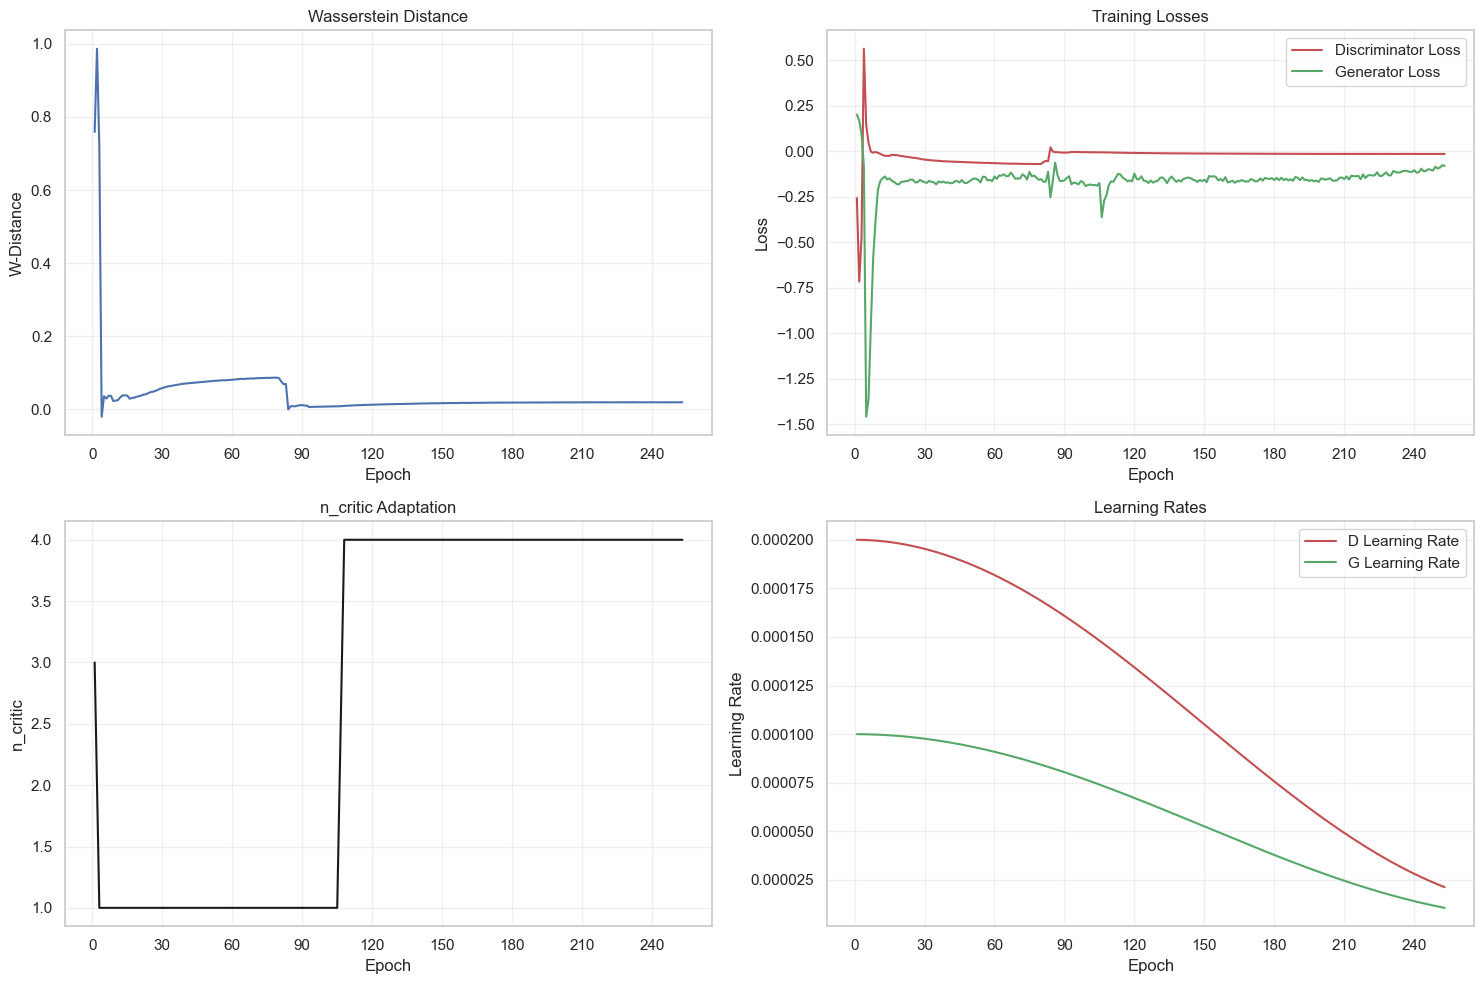

In [180]:
# Creating a GAN pipeline with GAN Config class
generator = GAN(real_df, metadata, GanConfig(epochs=300, patience=250))
# Training a GAN model with training plots
generator.fit(verbose=True)
# Generating synthetic data
synthetic_data_gan = generator.generate(synthetic_size)

In [198]:
# Creating a VAE pipeline with a VAE Config class
vae_pipe = VAEPipeline(real_df, metadata, VAEConfig(epochs=500))
# Training a VAE model with training plots
vae_pipe.fit(verbose=True)
# Generating synthetic data
synthetic_data_vae = vae_pipe.generate(synthetic_size)

KeyboardInterrupt: 

## 4. Quality Analysis

In [194]:
# Dictionary of datasets with their names
datasets = {
    'Original': real_df,
    'GAN': synthetic_data_gan,
    'VAE': synthetic_data_vae
}

In [202]:
print("\nNumeric Columns Describe (Original)")
display(real_df[num_cols].describe())


Numeric Columns Describe (Original)


Age  Flight Distance  Inflight wifi service  \
count  103594.000000    103594.000000          103594.000000   
mean       39.380466      1189.325202               2.729753   
std        15.113125       997.297235               1.327866   
min         7.000000        31.000000               0.000000   
25%        27.000000       414.000000               2.000000   
50%        40.000000       842.000000               3.000000   
75%        51.000000      1743.000000               4.000000   
max        85.000000      4983.000000               5.000000   

       Departure or Arrival time convenient  Ease of Online booking  \
count                         103594.000000           103594.000000   
mean                               3.060081                2.756984   
std                                1.525233                1.398934   
min                                0.000000                0.000000   
25%                                2.000000                2.000000   
50%                                3.000000                3.000000   
75%                                4.000000                4.000000   
max                                5.000000                5.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  103594.000000   103594.000000    103594.000000  103594.000000   
mean        2.977026        3.202126         3.250497       3.439765   
std         1.277723        1.329401         1.349433       1.318896   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max         5.000000        5.000000         5.000000       5.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103594.000000     103594.000000     103594.000000   
mean                 3.358341          3.382609          3.351401   
std                  1.333030          1.288284          1.315409   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service    Cleanliness  \
count     103594.000000    103594.000000     103594.000000  103594.000000   
mean           3.631687         3.304323          3.640761       3.286397   
std            1.181051         1.265396          1.175603       1.312194   
min            1.000000         0.000000          0.000000       0.000000   
25%            3.000000         3.000000          3.000000       2.000000   
50%            4.000000         3.000000          4.000000       3.000000   
75%            5.000000         4.000000          5.000000       4.000000   
max            5.000000         5.000000          5.000000       5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  
count               103594.000000             103594.000000  
mean                    14.747939                 15.178678  
std                     38.116737                 38.698682  
min                      0.000000                  0.000000  
25%                      0.000000                  0.000000  
50%                      0.000000                  0.000000  
75%                     12.000000                 13.000000  
max                   1592.000000               1584.000000

Gender   Customer Type           Age   Type of Travel     Class  \
count    50000           50000  50000.000000            50000     50000   
unique       2               2           NaN                2         3   
top     Female  Loyal Customer           NaN  Business travel  Business   
freq     25496           40831           NaN            34438     23800   
mean       NaN             NaN     39.471300              NaN       NaN   
std        NaN             NaN     15.018232              NaN       NaN   
min        NaN             NaN      7.000000              NaN       NaN   
25%        NaN             NaN     27.000000              NaN       NaN   
50%        NaN             NaN     40.000000              NaN       NaN   
75%        NaN             NaN     51.000000              NaN       NaN   
max        NaN             NaN     76.000000              NaN       NaN   

        Flight Distance  Inflight wifi service  \
count      50000.000000           50000.000000   
unique              NaN                    NaN   
top                 NaN                    NaN   
freq                NaN                    NaN   
mean        1164.560020               2.733180   
std          995.223281               1.271479   
min           77.000000               0.000000   
25%          416.750000               2.000000   
50%          788.000000               3.000000   
75%         1660.000000               4.000000   
max         3976.000000               5.000000   

        Departure or Arrival time convenient  Ease of Online booking  \
count                           50000.000000            50000.000000   
unique                                   NaN                     NaN   
top                                      NaN                     NaN   
freq                                     NaN                     NaN   
mean                                3.094560                2.771060   
std                                 1.500821                1.343281   
min                                 0.000000                0.000000   
25%                                 2.000000                2.000000   
50%                                 3.000000                3.000000   
75%                                 4.000000                4.000000   
max                                 5.000000                5.000000   

        Gate location  ...  Inflight entertainment  On-board service  \
count    50000.000000  ...            50000.000000      50000.000000   
unique            NaN  ...                     NaN               NaN   
top               NaN  ...                     NaN               NaN   
freq              NaN  ...                     NaN               NaN   
mean         2.977700  ...                3.372160          3.391540   
std          1.243219  ...                1.331305          1.241719   
min          1.000000  ...                1.000000          1.000000   
25%          2.000000  ...                2.000000          3.000000   
50%          3.000000  ...                4.000000          4.000000   
75%          4.000000  ...                5.000000          4.000000   
max          5.000000  ...                5.000000          5.000000   

        Leg room service  Baggage handling  Checkin service  Inflight service  \
count       50000.000000      50000.000000     50000.000000      50000.000000   
unique               NaN               NaN              NaN               NaN   
top                  NaN               NaN              NaN               NaN   
freq                 NaN               NaN              NaN               NaN   
mean            3.384120          3.662760         3.334400          3.685740   
std             1.240243          1.122521         1.165918          1.139125   
min             0.000000          1.000000         1.000000          1.000000   
25%             2.000000          3.000000         3.000000          3.000000   
50%             4.000000          4.000000     

#### Статистичні метрики оригінального та синтетичних датасетів

In [119]:
#todo numeric
#Wasserstein distance
#Kolmogorov–Smirnov statistic
#Kullback–Leibler divergence

#todo categorical
#Categorical Mean Absolute Error
#Chi-square statistic
#p-value

#### Генерування фейкових строкових даних

In [200]:
# Get value counts for each dataset's city column
orig = real_df['City'].value_counts(normalize=True).sort_index()
gan = synthetic_data_gan['City'].value_counts(normalize=True).reindex(orig.index, fill_value=0)
#vae = synthetic_data_vae['City'].value_counts(normalize=True).reindex(orig.index, fill_value=0)

# Build DataFrames for plotting
df_gan_counts = pd.DataFrame({'Original': orig, 'GAN': gan})
df_vae_counts = pd.DataFrame({'Original': orig, 'VAE': gan})

# Create 1×2 subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot Original vs GAN
df_gan_counts.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
axes[0].set_title('City: Original vs GAN')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', rotation=45, ha='right')

# Plot Original vs VAE  
df_vae_counts.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
axes[1].set_title('City: Original vs VAE')
axes[1].tick_params(axis='x', rotation=45, ha='right')

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


KeyError: 'ity'

#### Порівняння розподілів числових колонок у оригінальному та синтетичних датасетах

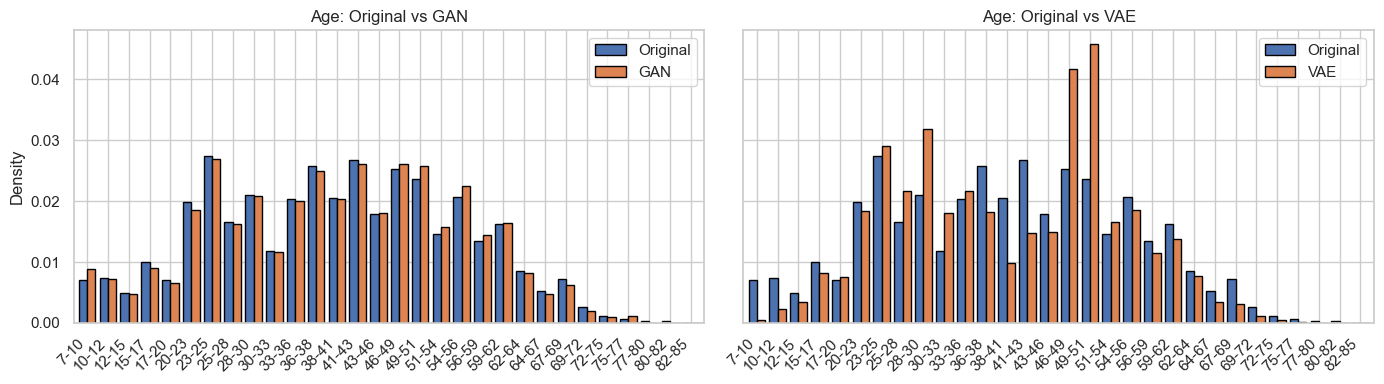

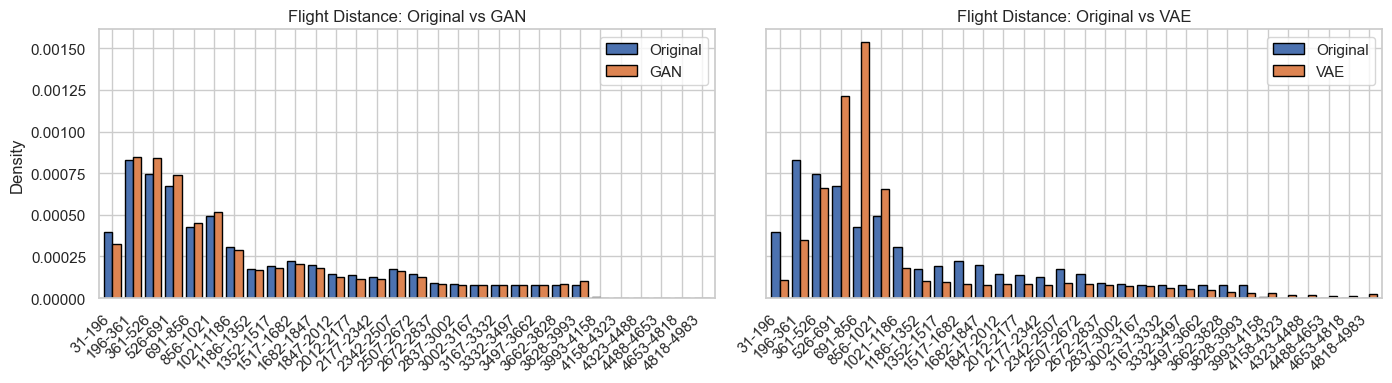

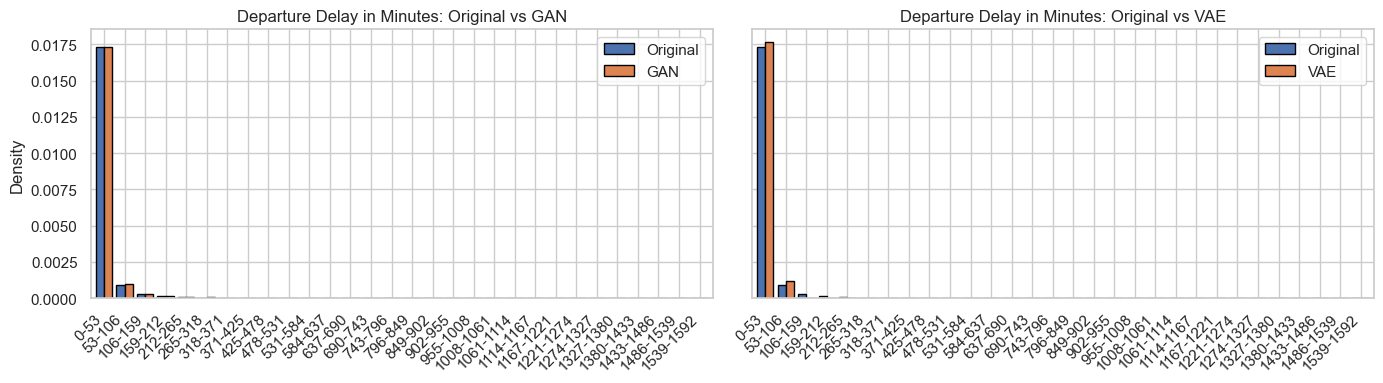

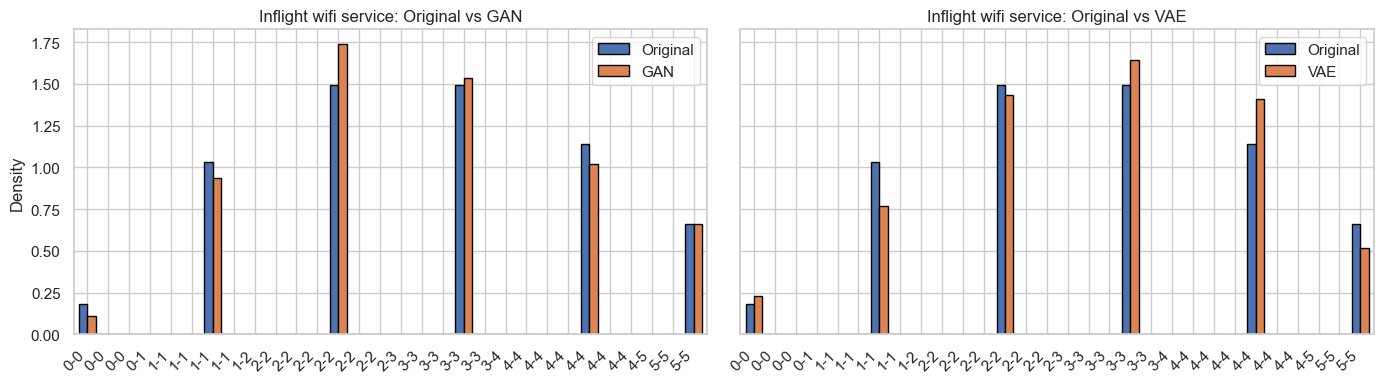

In [185]:
for col in ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Inflight wifi service']:
    orig_vals = real_df[col].dropna().values
    gan_vals  = synthetic_data_gan[col].dropna().values
    vae_vals  = synthetic_data_vae[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts,  _ = np.histogram(gan_vals,  bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({'Original': orig_counts, 'GAN': gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({'Original': orig_counts, 'VAE': vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel('Density')

    df_ov.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend()
    plt.tight_layout()
    plt.show()

#### Порівняння розподілів категоріальних колонок у оригінальному та синтетичних датасетах

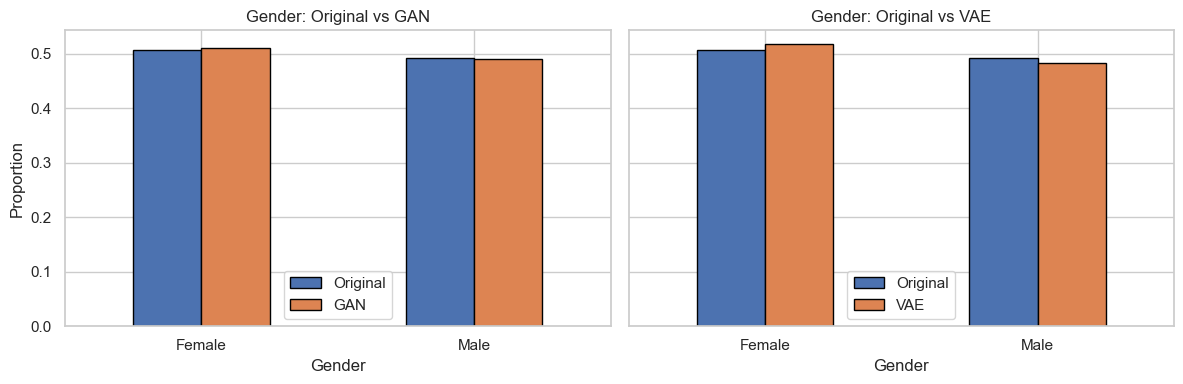

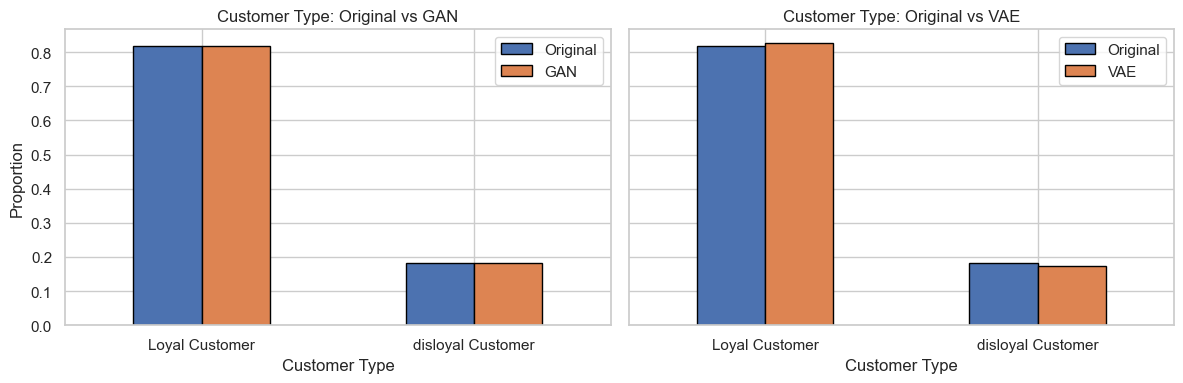

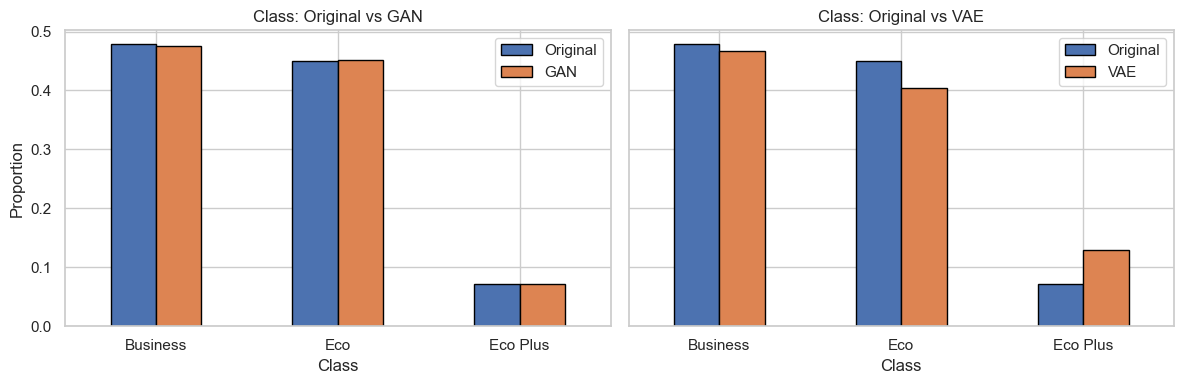

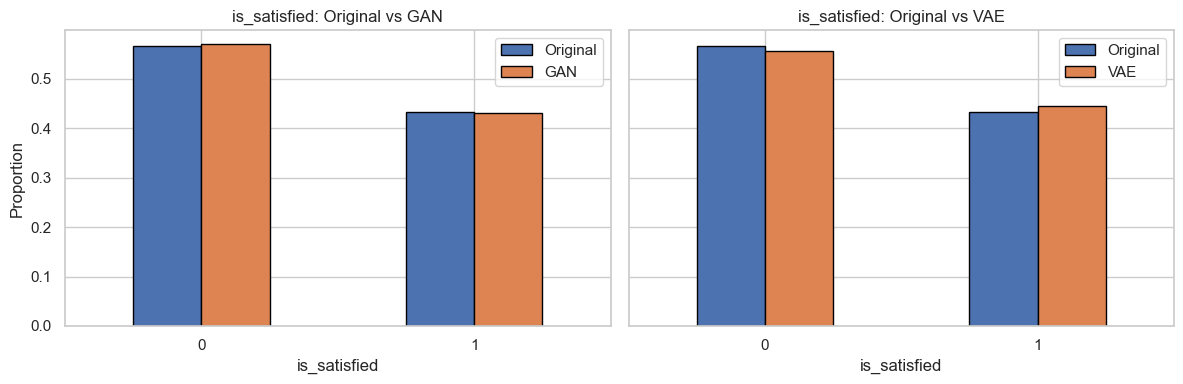

In [186]:
for col in cat_bool_cols:
    # Prepare normalized proportions as strings to avoid mixed-type ordering issues
    orig = real_df[col].fillna('NaN').astype(str).value_counts(normalize=True).sort_index()
    gan  = synthetic_data_gan[col].fillna('NaN').astype(str).value_counts(normalize=True).reindex(orig.index, fill_value=0)
    vae  = synthetic_data_vae[col].fillna('NaN').astype(str).value_counts(normalize=True).reindex(orig.index, fill_value=0)

    # Build DataFrames for side-by-side bar plots
    df_gan_counts = pd.DataFrame({'Original': orig, 'GAN': gan})
    df_vae_counts = pd.DataFrame({'Original': orig, 'VAE': vae})

    # Create 1×2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot Original vs GAN
    df_gan_counts.plot(kind='bar', ax=axes[0], edgecolor='black')
    axes[0].set_title(f'{col}: Original vs GAN')
    axes[0].set_ylabel('Proportion')

    # Plot Original vs VAE
    df_vae_counts.plot(kind='bar', ax=axes[1], edgecolor='black')
    axes[1].set_title(f'{col}: Original vs VAE')

    # Tidy up tick labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend()

    plt.tight_layout()
    plt.show()


#### Визначаємо службові методи для створення кореляційних матриць (numeric-numeric та categorical-numeric)

In [187]:
def correlation_num_to_num_matrix_plot(df1, df2, columns, title_prefix=""):
    """
    Plots numeric-numeric correlations for Real vs Synthetic and their absolute difference.
    """
    corr_orig = df1[columns].corr()
    corr_gan  = df2[columns].corr()
    diff_gan  = (corr_orig - corr_gan).abs()

    # 2) Original heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_orig, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title("Numeric-Numeric Correlation — Original")
    plt.tight_layout()
    plt.show()

    # 3) GAN heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_gan, vmin=-1, vmax=1, cmap="vlag", annot=False, fmt=".2f")
    plt.title(f"Numeric-Numeric Correlation — {title_prefix}")
    plt.tight_layout()
    plt.show()

    # 4) Absolute-difference heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(diff_gan, vmin=0, vmax=1, cmap="rocket_r", annot=False, fmt=".2f")
    plt.title(f"Absolute Difference |Original – {title_prefix}|")
    plt.tight_layout()
    plt.show()

def correlation_cat_num_matrix_plot(df1, df2, columns_num, columns_cat, title_prefix=""):
    """
    Plots n2 (categorical-numeric) correlations for Real vs Synthetic and their absolute difference.
    """
    # Encode categoricals
    cat_codes1 = df1[columns_cat].apply(lambda s: s.astype('category').cat.codes)
    cat_codes2 = df2[columns_cat].apply(lambda s: s.astype('category').cat.codes)

    combined1 = pd.concat([cat_codes1, df1[columns_num]], axis=1)
    combined2 = pd.concat([cat_codes2, df2[columns_num]], axis=1)

    eta1 = combined1.corr().loc[columns_cat, columns_num]
    eta2 = combined2.corr().loc[columns_cat, columns_num]
    diff = (eta1 - eta2).abs()

    for mat, title in zip([eta1, eta2, diff], ["η² Real", "η² Synthetic", "η² Abs Diff"]):
        fig, ax = plt.subplots(figsize=(1.5 * len(columns_num), 0.5 * len(cat_cols) + 3))
        sns.heatmap(mat, annot=True, fmt=".2f",
                    xticklabels=columns_num, yticklabels=columns_cat,
                    cmap="rocket_r", vmin=0, vmax=1, ax=ax)
        ax.set_title(f"{title} ({title_prefix})")
        plt.tight_layout()
        plt.show()

    return eta1, eta2, diff

#### Порівняння кореляційних матриць числових колонок у оригінальному та синтетичних датасетах

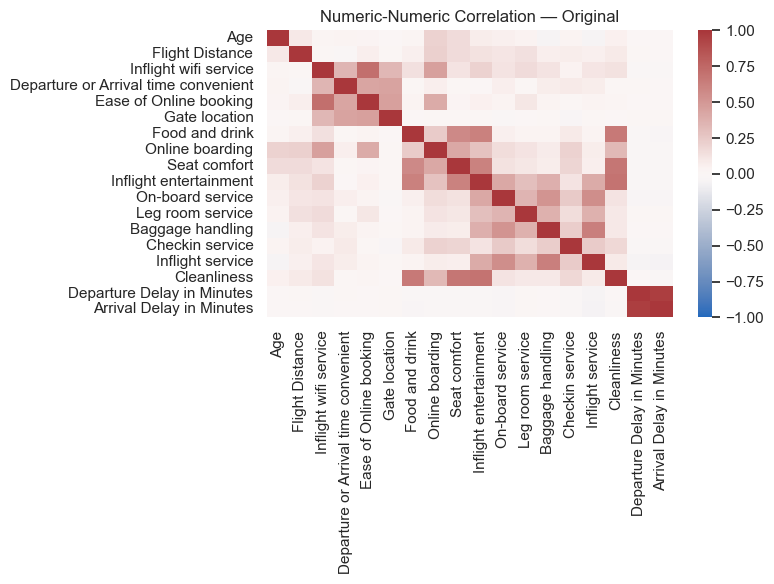

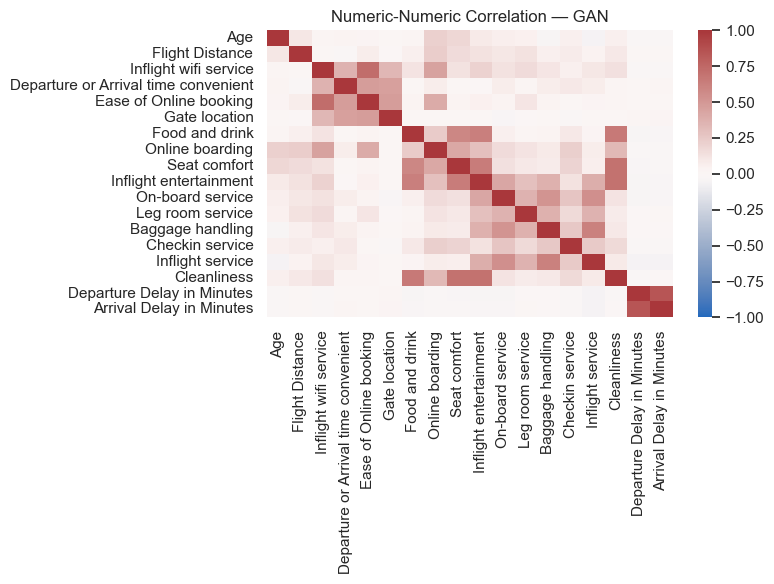

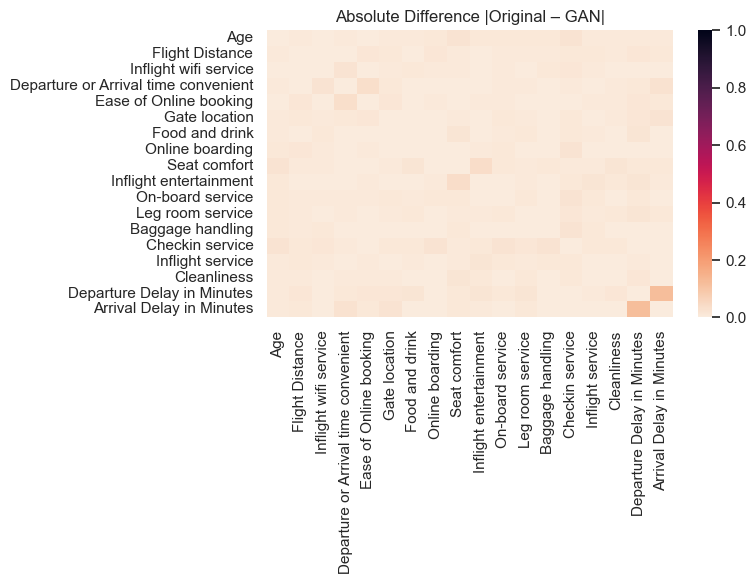

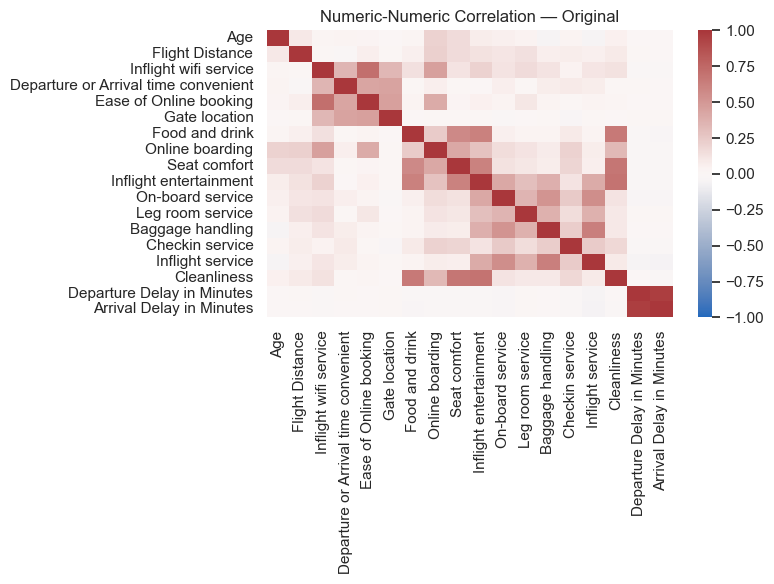

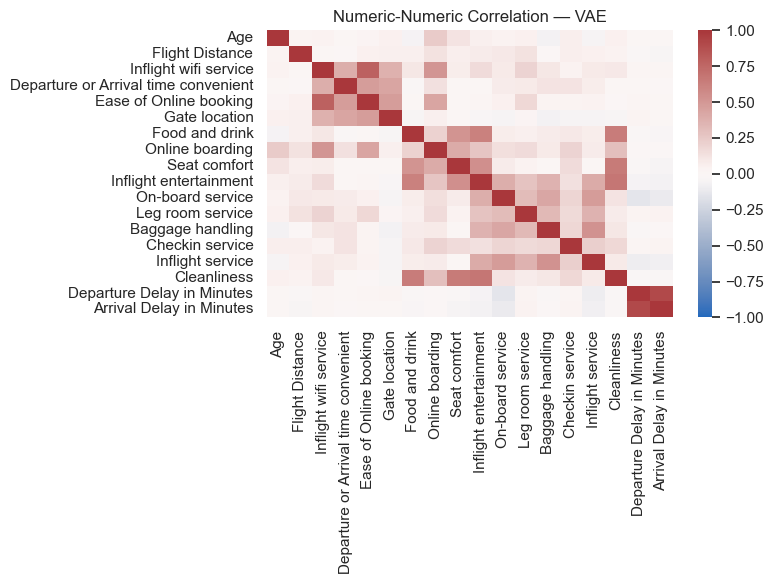

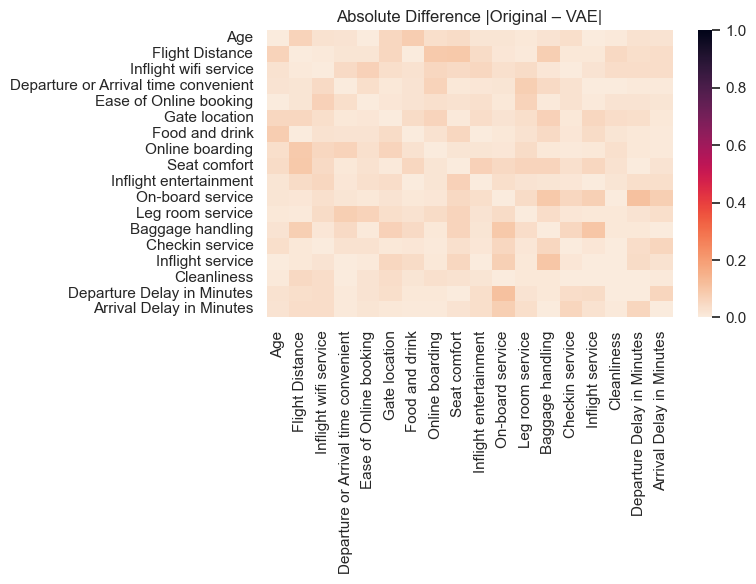

In [135]:
correlation_num_to_num_matrix_plot(real_df, synthetic_data_gan, num_cols, "GAN")
correlation_num_to_num_matrix_plot(real_df, synthetic_data_vae, num_cols, "VAE")

#### Порівняння кореляційних матриць категоріальних колонок до числових у оригінальному та синтетичних датасетах

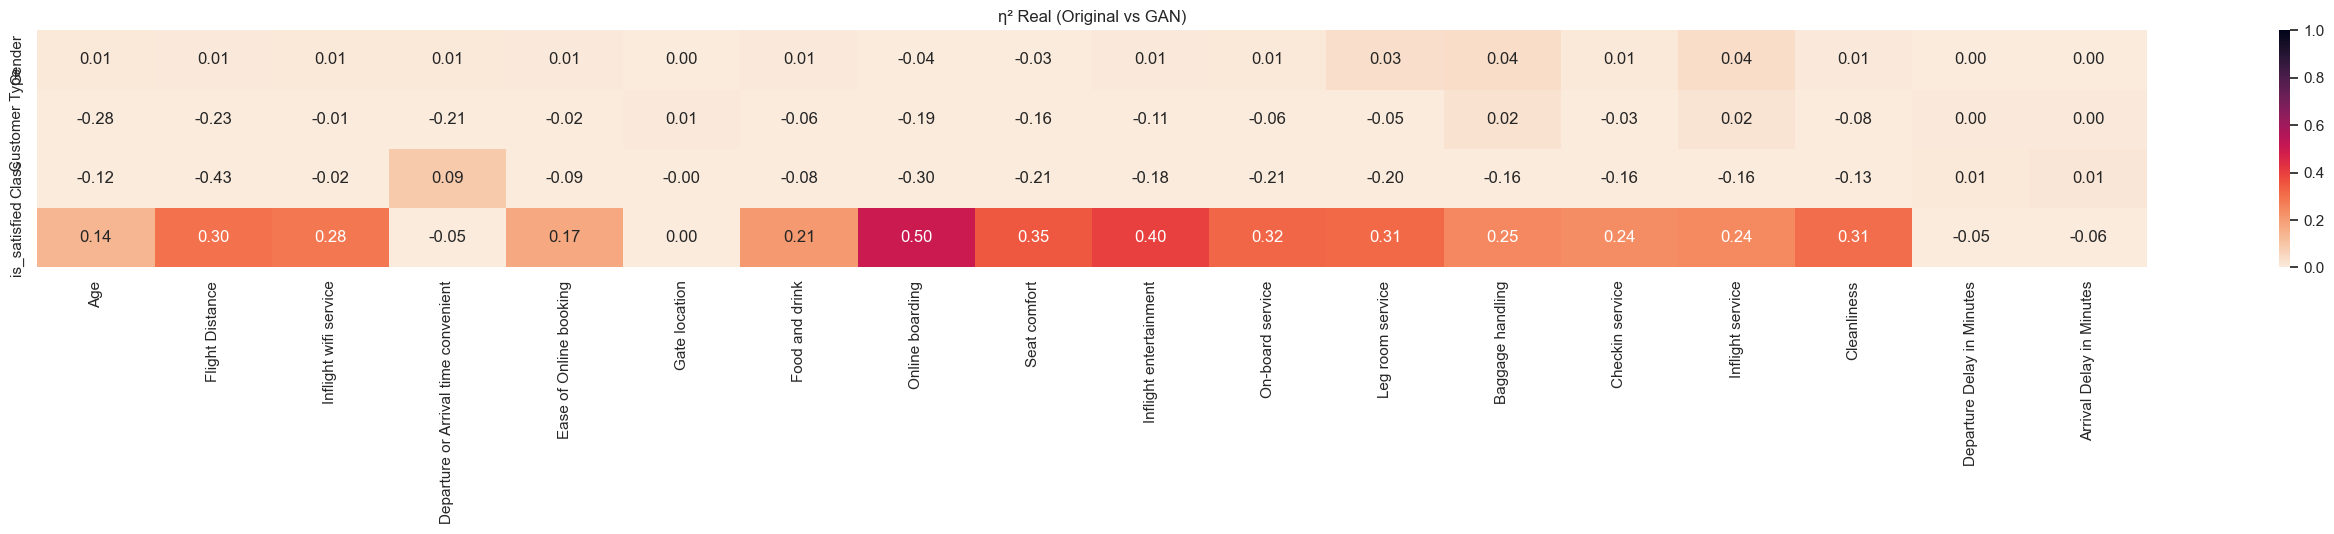

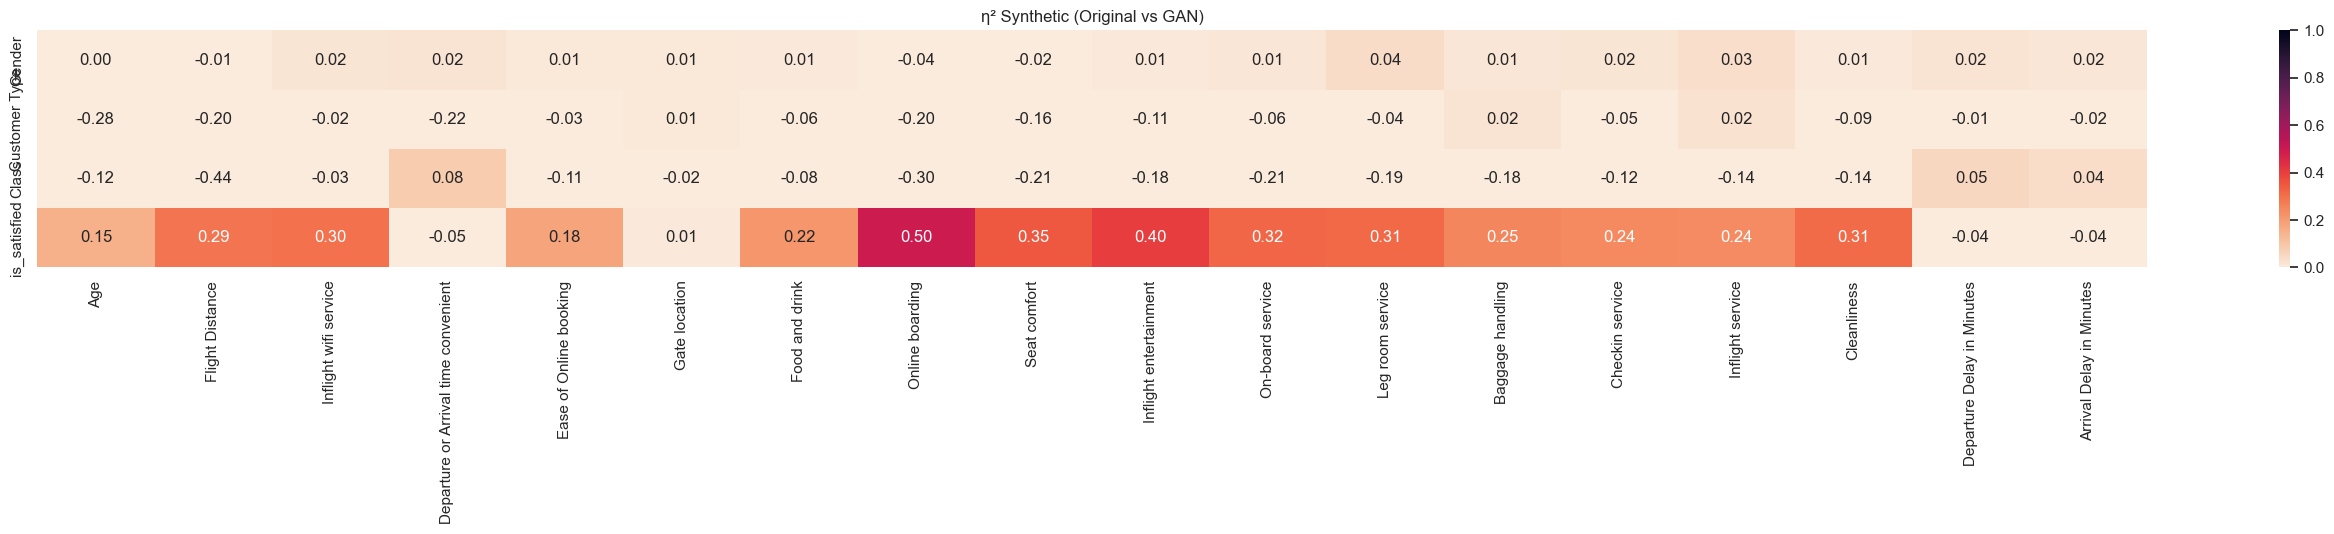

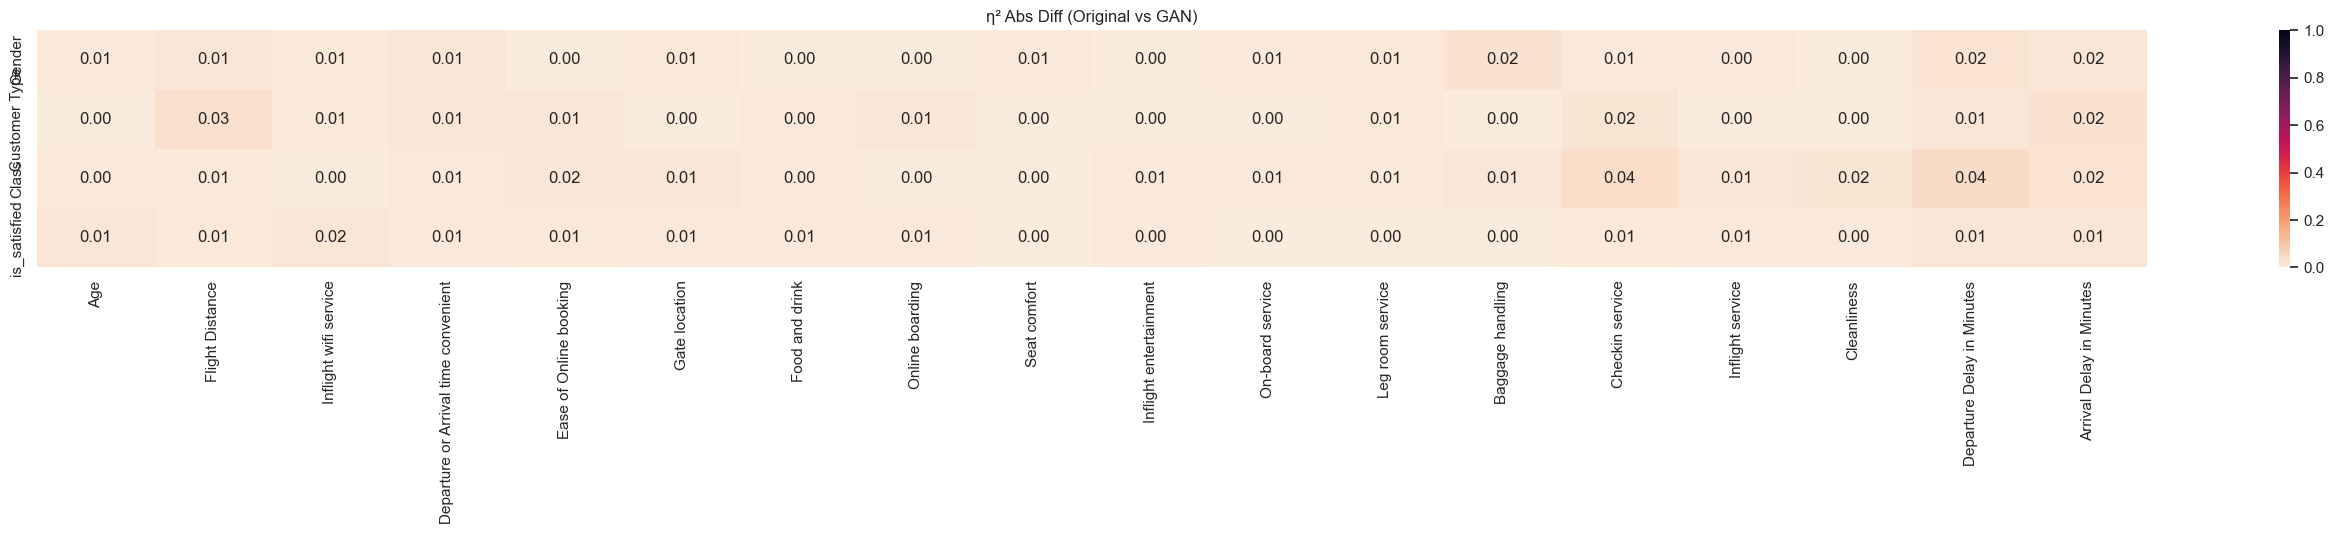

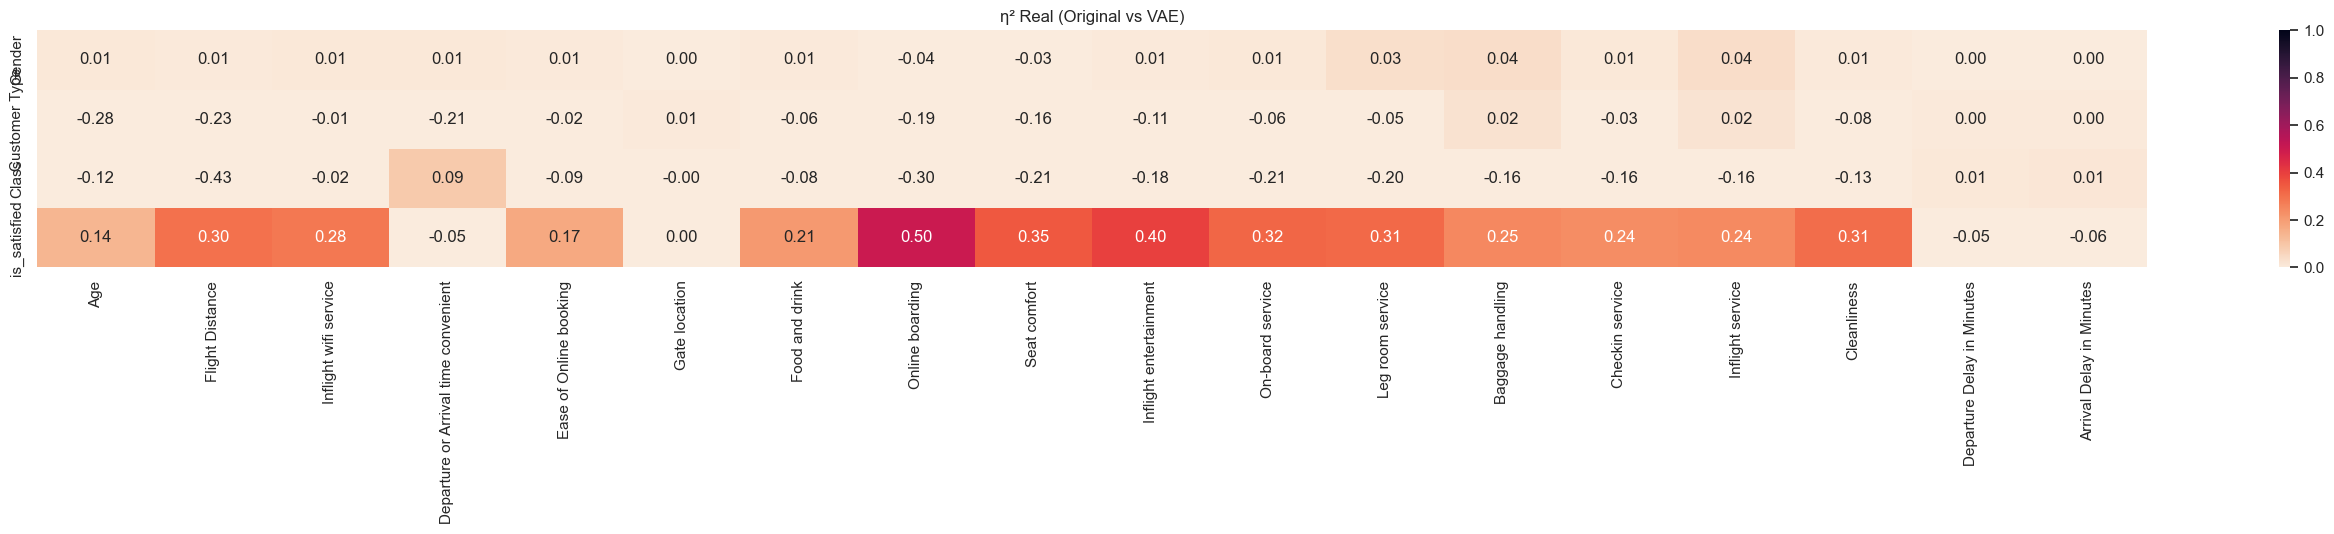

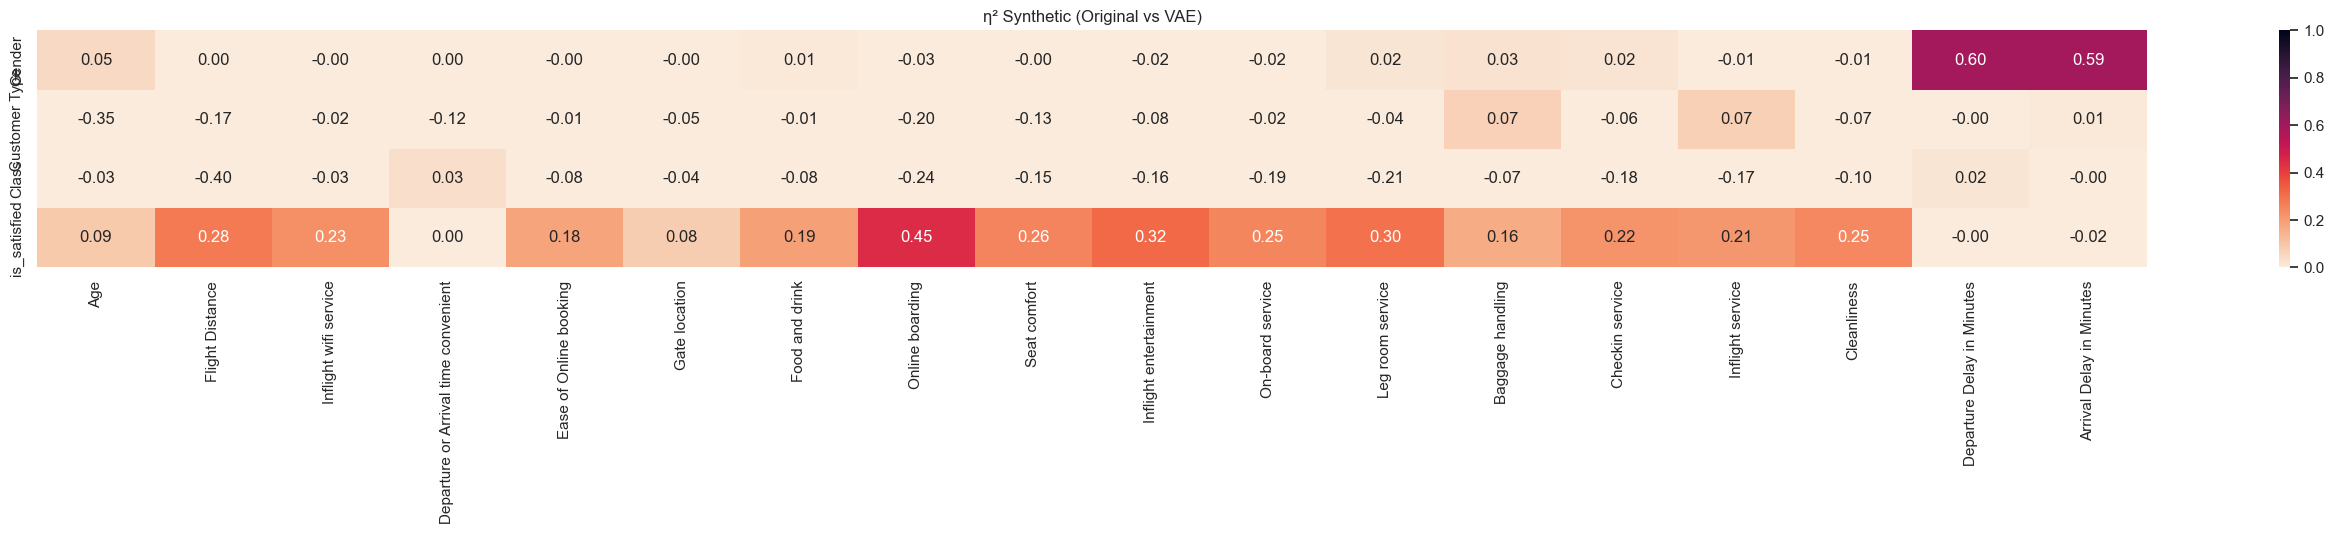

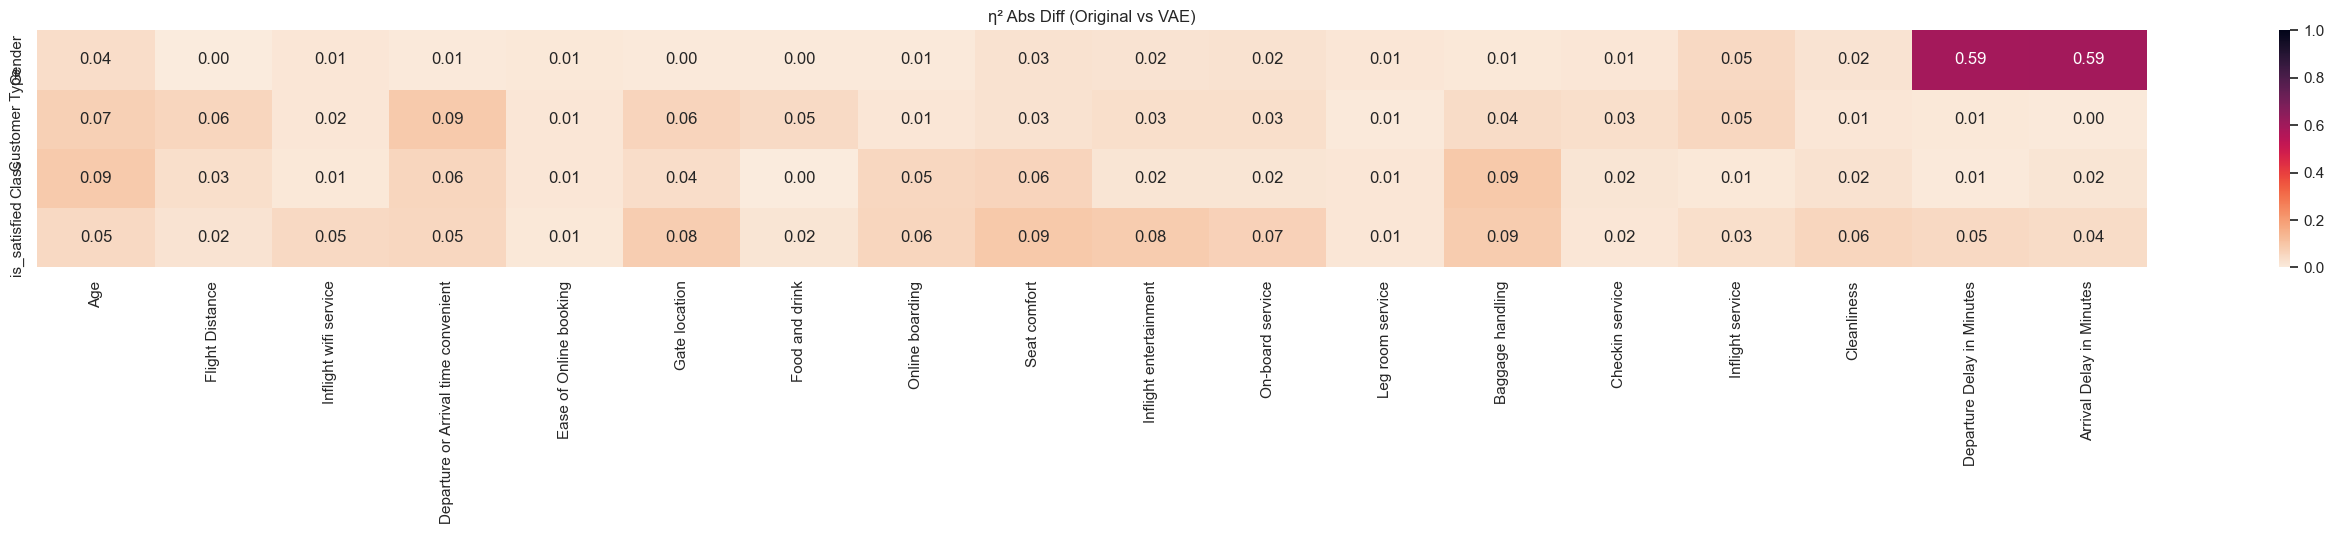

In [188]:
eta_gan = correlation_cat_num_matrix_plot(real_df, synthetic_data_gan, num_cols, cat_bool_cols, "Original vs GAN")
eta_vae = correlation_cat_num_matrix_plot(real_df, synthetic_data_vae, num_cols, cat_bool_cols, "Original vs VAE")

#### PCA

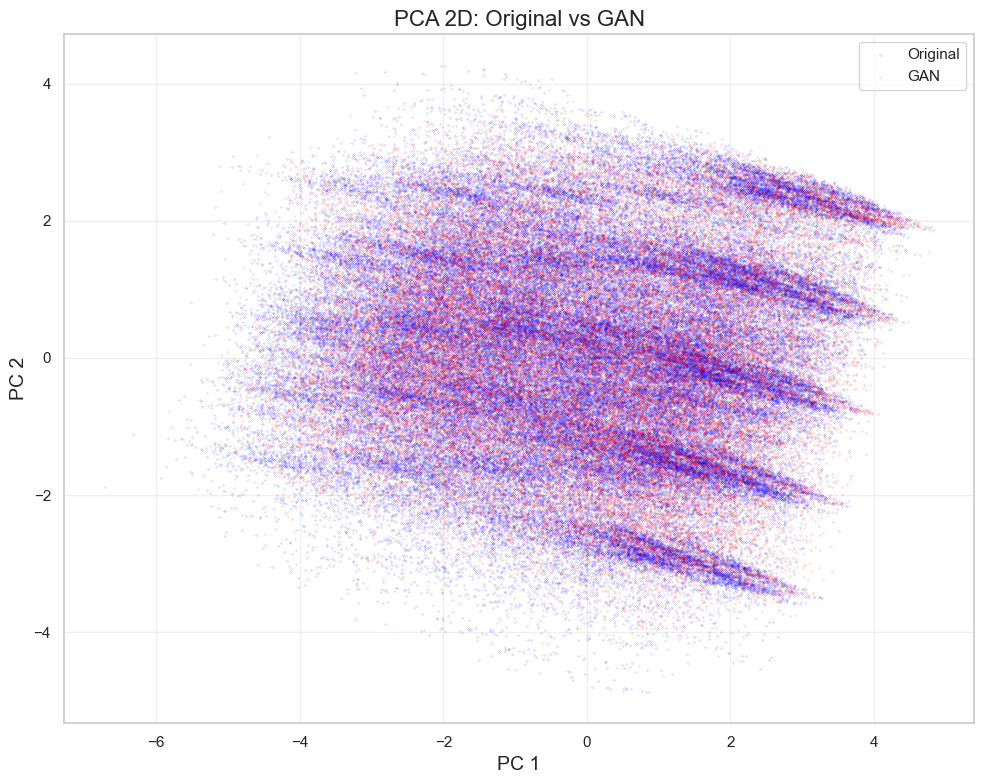

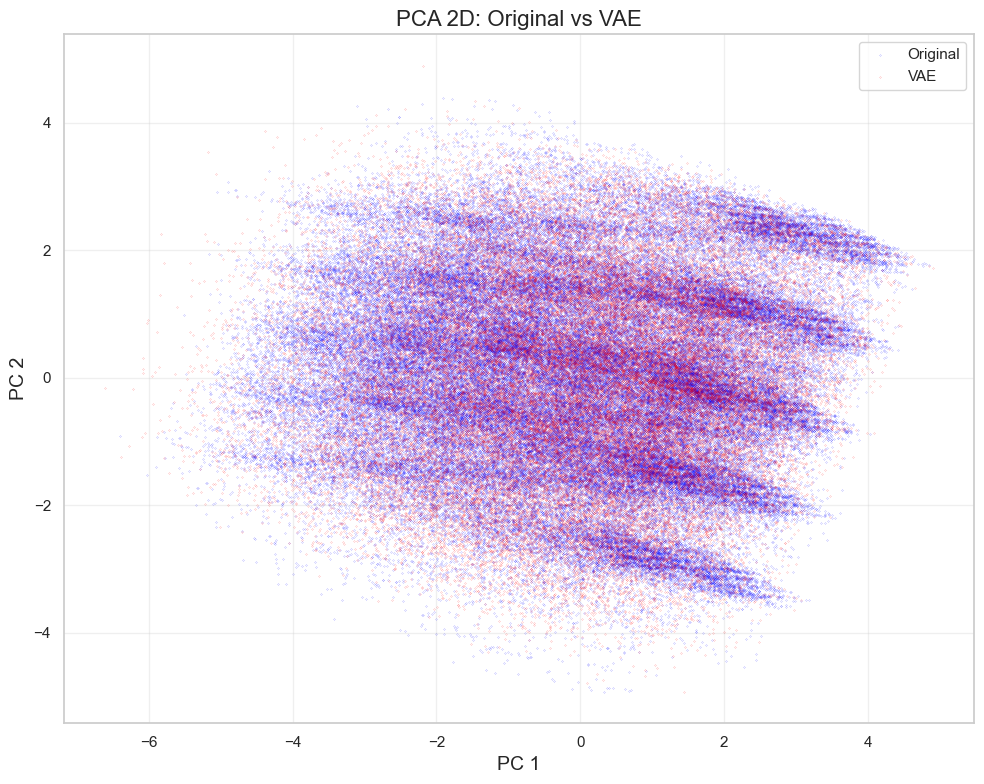

In [189]:
from sklearn.decomposition import PCA

# Standardize original data once
X_orig = StandardScaler().fit_transform(real_df[num_cols].fillna(0))

# Prepare synthetic arrays (scaled with same scaler for comparability)
scaler = StandardScaler().fit(real_df[num_cols].fillna(0))
X_gan = scaler.transform(synthetic_data_gan[num_cols].fillna(0))
X_vae = scaler.transform(synthetic_data_vae[num_cols].fillna(0))

# Plotting function
def pca_compare(X_other, label):
    X_comb = np.vstack([X_orig, X_other])
    comps = PCA(n_components=2).fit_transform(X_comb)
    n = X_orig.shape[0]
    plt.figure(figsize=(10, 8))
    plt.scatter(comps[:n,0], comps[:n,1], s=0.01, c='blue', label='Original')
    plt.scatter(comps[n:,0], comps[n:,1], s=0.01, c='red', label=label)
    plt.title(f'PCA 2D: Original vs {label}', fontsize=16)
    plt.xlabel('PC 1', fontsize=14)
    plt.ylabel('PC 2', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate the two plots
pca_compare(X_gan, 'GAN')
pca_compare(X_vae, 'VAE')

#### t-SNE

In [ ]:
# todo

## 5. Discriminator

In [190]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    confusion_matrix, classification_report
)

from sklearn.base import BaseEstimator, TransformerMixin

class GaussianNoise(BaseEstimator, TransformerMixin):
    def __init__(self, std=0.02, random_state=42):
        self.std = std
        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X + self.rng.normal(0, self.std, X.shape)


def run_discriminator(
    real_df:   pd.DataFrame,
    synth_df:  pd.DataFrame,
    name:      str,
    *,
    n_components: int = 10,
    noise_std:    float = 0.02,
    random_state: int   = 42,
):
    # 1) label & stack
    real  = real_df.copy();  real ['__label'] = 0
    synth = synth_df.copy(); synth['__label'] = 1
    df    = pd.concat([real, synth], ignore_index=True)

    X = df.drop(columns='__label')
    y = df['__label']

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.30, random_state=random_state
    )

    # 2) column groups
    numeric_cols = X.select_dtypes(include=['number', 'bool']).columns.tolist()
    categoric_cols = [c for c in X.columns if c not in num_cols]

    # 3) preprocessing pipelines
    num_pipe = Pipeline([
        ('sc',    StandardScaler()),
        ('noise', GaussianNoise(std=noise_std, random_state=random_state))
    ])

    # convert every categorical column to string → avoids mixed-type error
    cat_pipe = Pipeline([
        ('to_str', FunctionTransformer(lambda x: x.astype(str), feature_names_out='one-to-one')),
        ('ohe',    OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    prep = ColumnTransformer(
        [('num', num_pipe, numeric_cols),
         ('cat', cat_pipe, categoric_cols)],
        remainder='drop'
    )

    # 4) full pipeline
    model = Pipeline([
        ('prep', prep),
        ('pca',  PCA(n_components=n_components, random_state=random_state)),
        ('clf',  LogisticRegression(max_iter=1000,
                                    C=0.1,            # strong L2 regularisation
                                    class_weight='balanced',
                                    random_state=random_state))
    ])

    # 5) train & report
    model.fit(X_tr, y_tr)
    y_pred  = model.predict(X_te)
    y_prob  = model.predict_proba(X_te)[:, 1]

    print(f"\n{name} Discriminator: ")
    print("Accuracy :", accuracy_score(y_te, y_pred))
    print("ROC AUC  :", roc_auc_score(y_te, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification Report:\n", classification_report(y_te, y_pred))


run_discriminator(real_df, synthetic_data_gan, "GAN")
run_discriminator(real_df, synthetic_data_vae, "VAE")



GAN Discriminator: 
Accuracy : 0.5005968011458583
ROC AUC  : 0.5131305168548966
Confusion Matrix:
 [[15151 15928]
 [ 7084  7916]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.49      0.57     31079
           1       0.33      0.53      0.41     15000

    accuracy                           0.50     46079
   macro avg       0.51      0.51      0.49     46079
weighted avg       0.57      0.50      0.52     46079


VAE Discriminator: 
Accuracy : 0.6134247705028321
ROC AUC  : 0.641852436264573
Confusion Matrix:
 [[19388 11691]
 [ 6122  8878]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.62      0.69     31079
           1       0.43      0.59      0.50     15000

    accuracy                           0.61     46079
   macro avg       0.60      0.61      0.59     46079
weighted avg       0.65      0.61      0.62     46079



# Household Power Consumption Dataset

## Препроцессинг та генерація даних

##### Препроцессинг датасету. Формування почасового датасету

In [177]:
# Loading dataset
raw = pd.read_csv(
    'datasets/household_power_consumption.csv',
    sep=';',
    dayfirst=True,
    na_values='?'
)
# Parse datetime explicitly to avoid FutureWarning
raw['dt'] = pd.to_datetime(
    raw['Date'].str.strip() + ' ' + raw['Time'].str.strip(),
    format='%d/%m/%Y %H:%M:%S',
    dayfirst=True,
    errors='coerce'
)
# Drop rows where parsing failed
df_power = raw.dropna(subset=['dt']).drop(columns=['Date', 'Time'])

# Aggregate to hourly sums and drop any remaining NaNs
df_hourly = (
    df_power
    .dropna()
    .set_index('dt')
    .resample('h')
    .sum()
)
# Extract one full year (2008)
year_df = df_hourly['2006-12-16':'2009-12-31']
print("Loaded hourly data shape:", year_df.shape)
display(year_df.head())

Loaded hourly data shape: (26671, 7)


Global_active_power  Global_reactive_power   Voltage  \
dt                                                                          
2006-12-16 17:00:00              152.024                  8.244   8447.18   
2006-12-16 18:00:00              217.932                  4.802  14074.81   
2006-12-16 19:00:00              204.014                  5.114  13993.95   
2006-12-16 20:00:00              196.114                  4.506  14044.29   
2006-12-16 21:00:00              183.388                  4.600  14229.52   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:00:00             651.6             0.0            19.0   
2006-12-16 18:00:00             936.0             0.0           403.0   
2006-12-16 19:00:00             870.2             0.0            86.0   
2006-12-16 20:00:00             835.0             0.0             0.0   
2006-12-16 21:00:00             782.8             0.0            25.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:00:00           607.0  
2006-12-16 18:00:00          1012.0  
2006-12-16 19:00:00          1001.0  
2006-12-16 20:00:00          1007.0  
2006-12-16 21:00:00          1033.0

##### Визначаємо метадані датасету для генерації

In [151]:
gen_meta_full = {
    'Global_active_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Global_reactive_power': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Voltage': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Global_intensity': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Sub_metering_1': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Sub_metering_2': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
    'Sub_metering_3': FieldMetadata(data_type=DataType.DECIMAL, decimal_places=3),
}

##### Генерація даних за допомогою GAN та VAE нейромереж

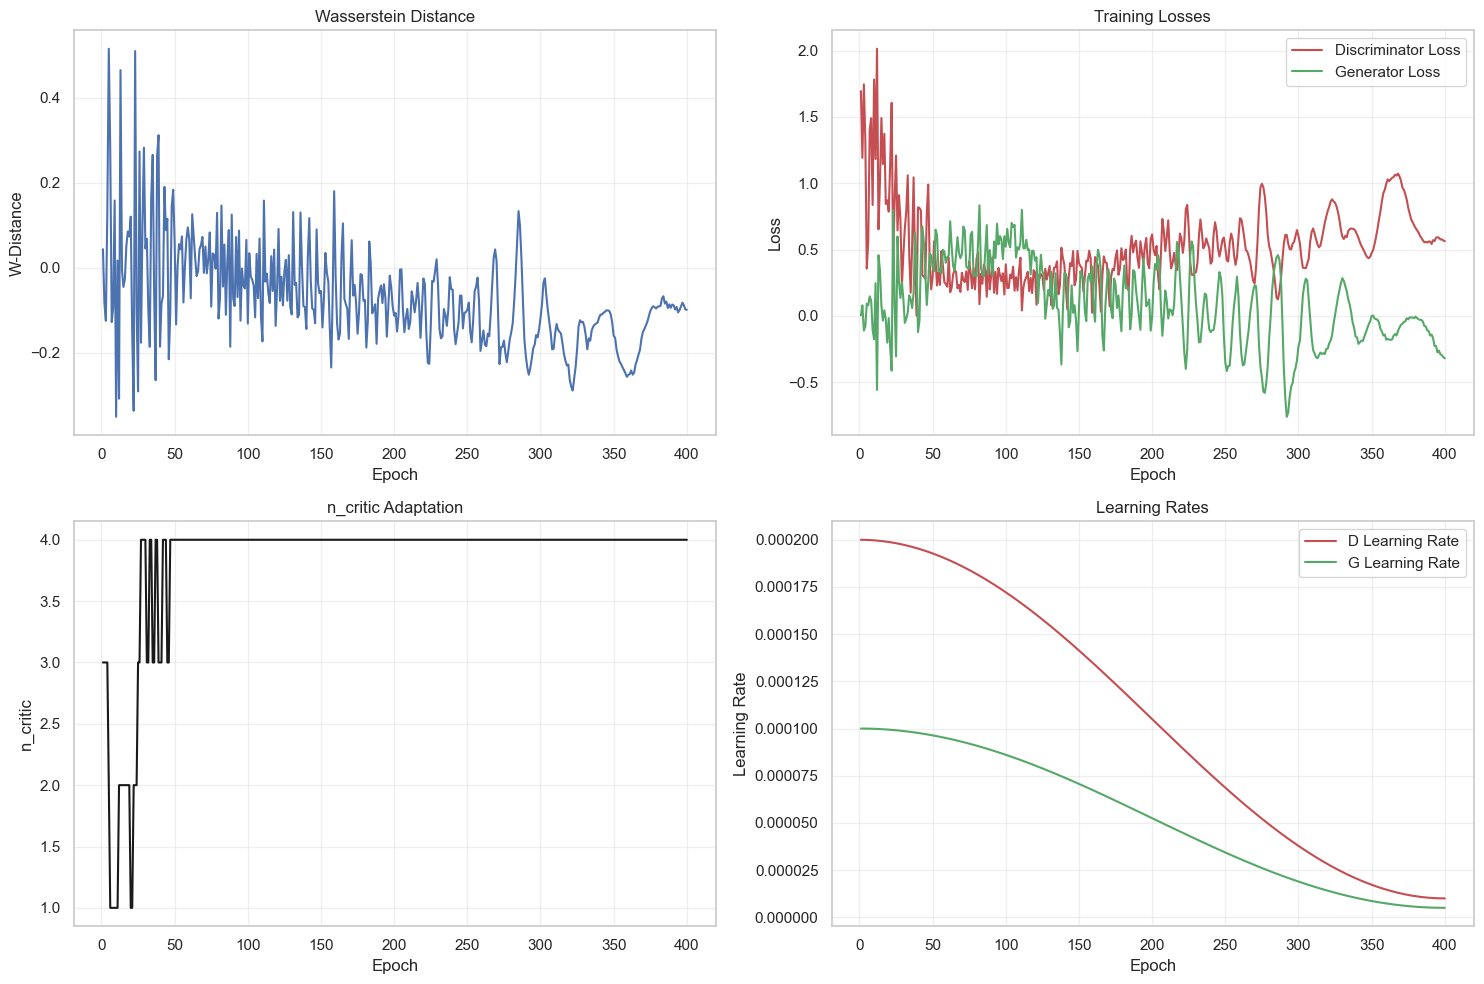

In [156]:
gan_full = GAN(year_df, gen_meta_full, GanConfig(epochs=400, patience=400))
gan_full.fit(verbose=True)
S_gan_full = gan_full.generate(len(year_df))

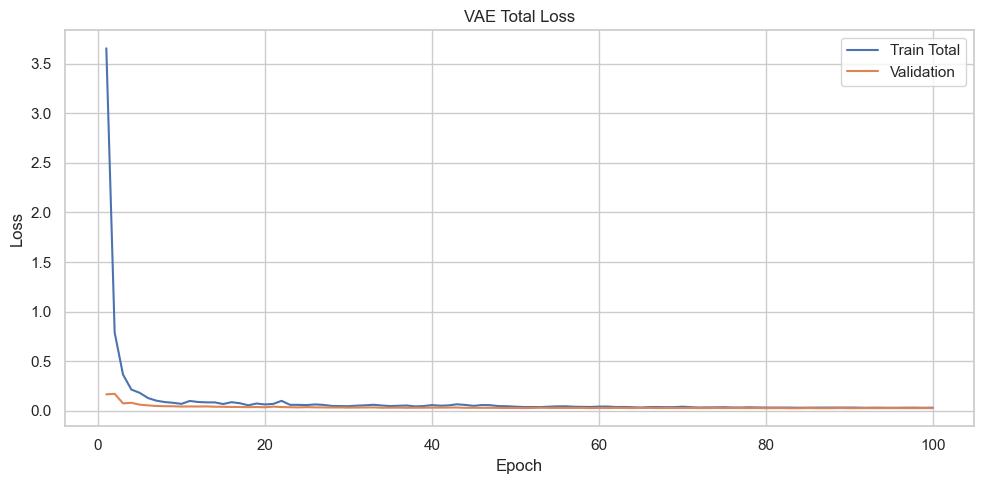

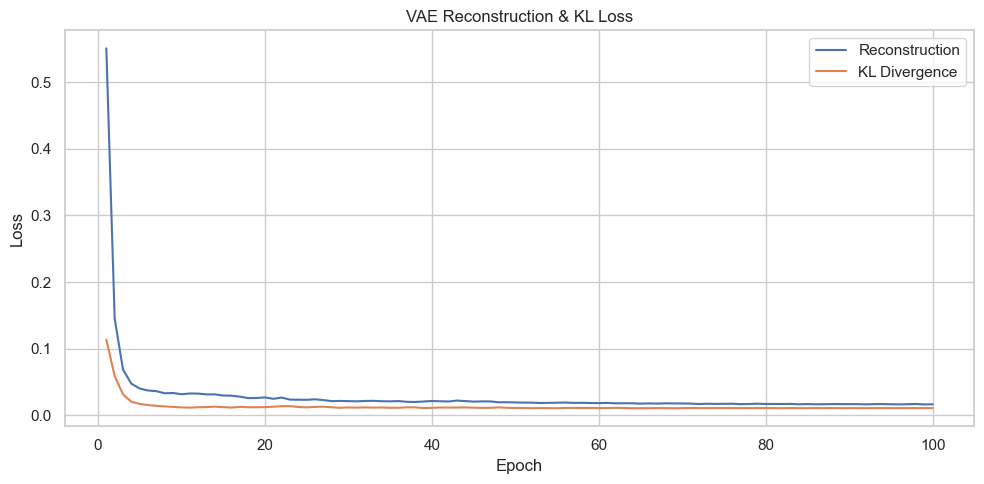

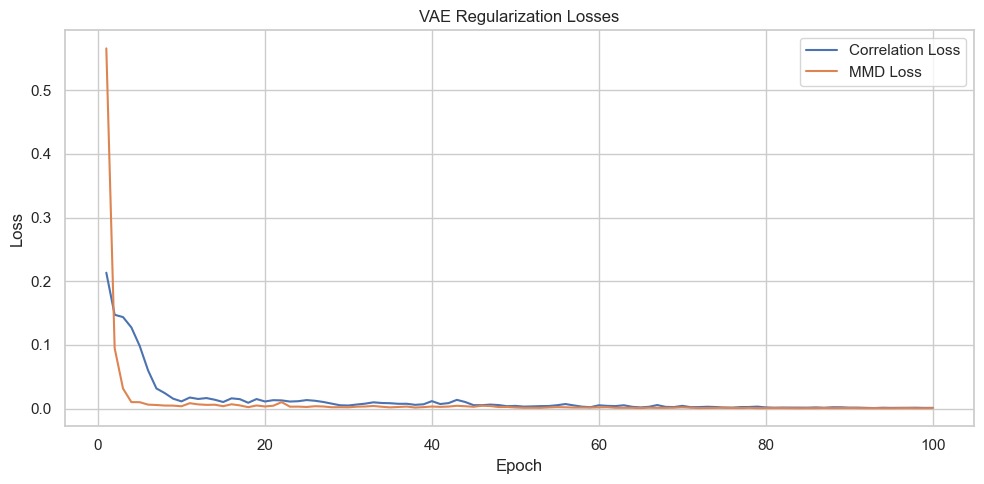

In [155]:
vae_full = VAEPipeline(year_df, gen_meta_full, VAEConfig(epochs=100))
vae_full.fit(verbose=True)
S_vae_full = vae_full.generate(len(year_df))

##### Статистичний аналіз синтетичних даних

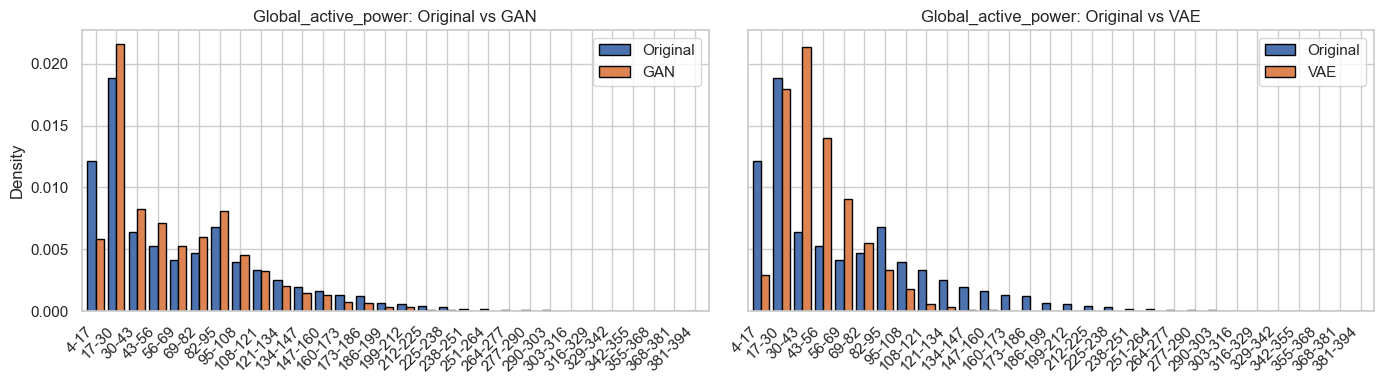

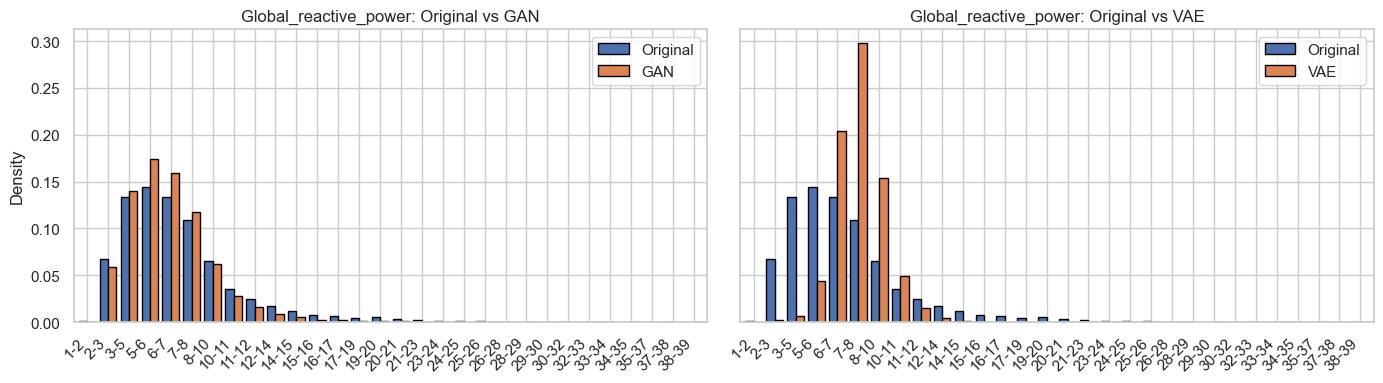

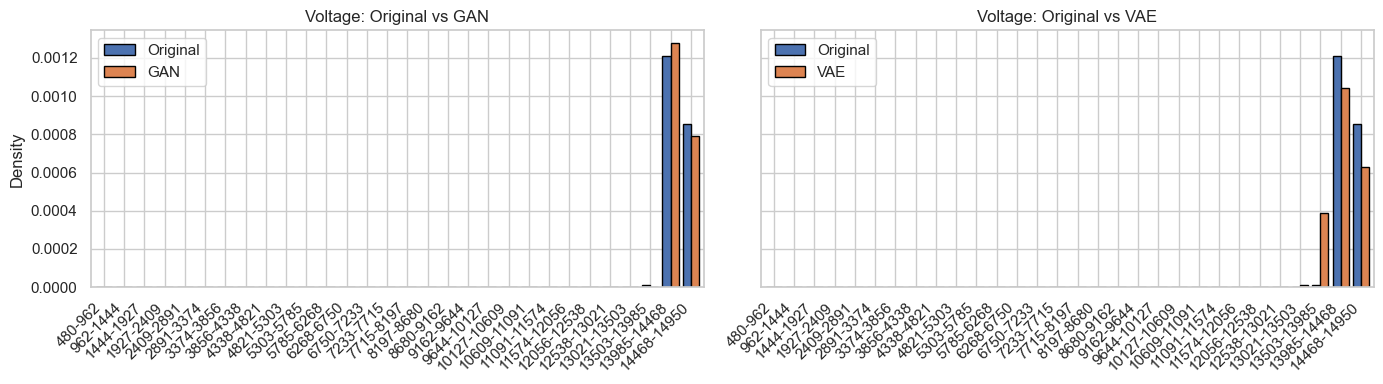

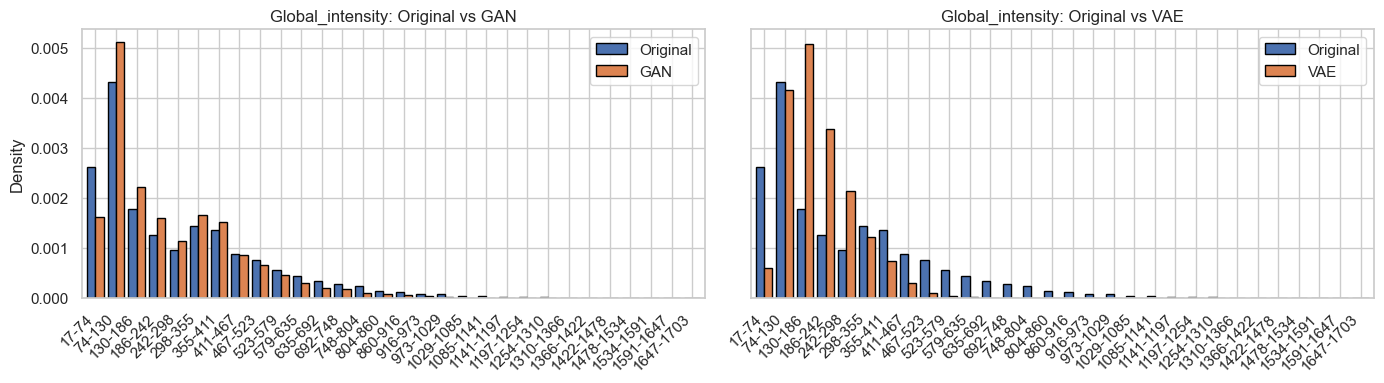

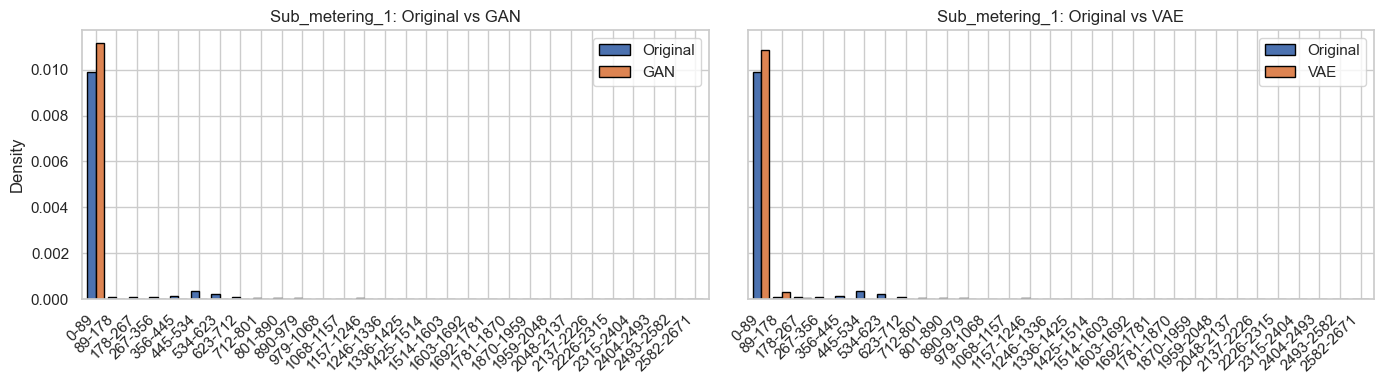

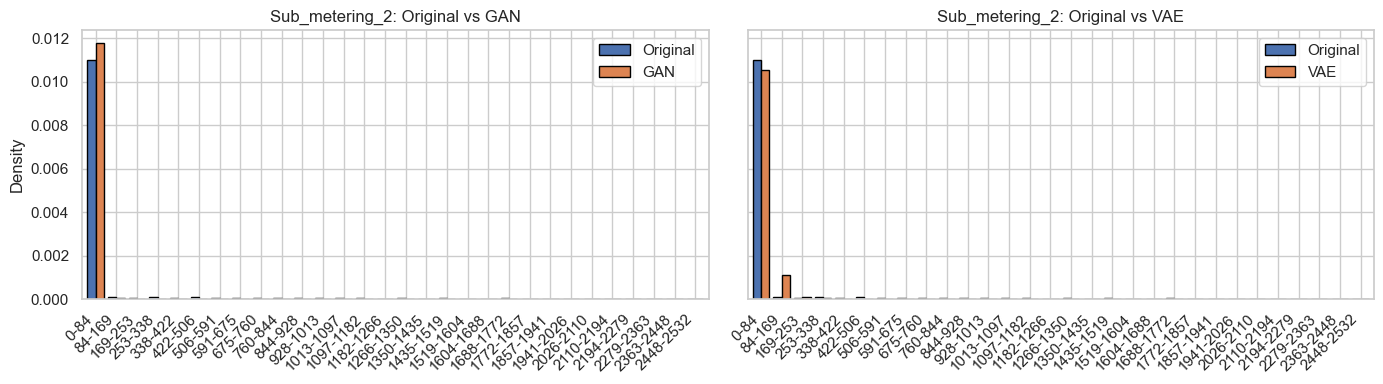

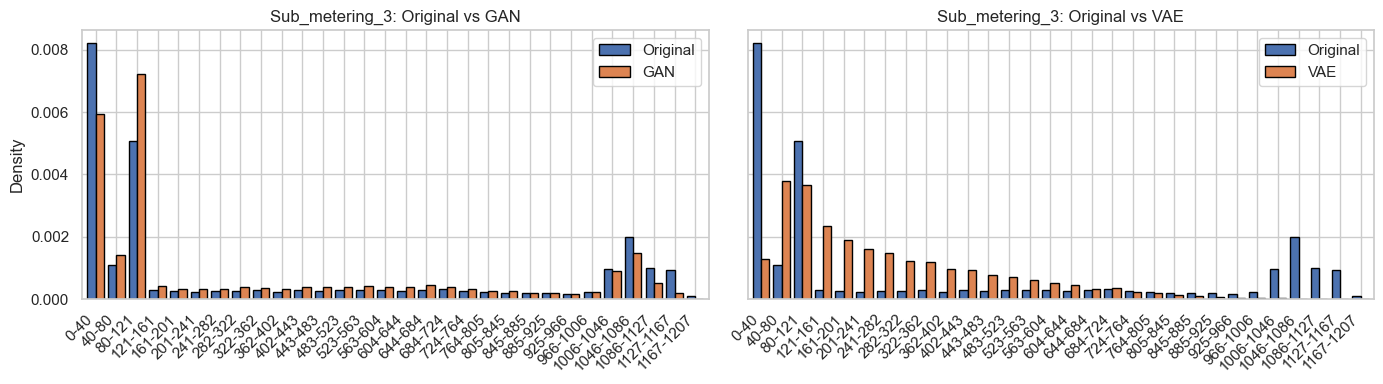

In [163]:
for col in list(gen_meta_full.keys()):
    orig_vals = year_df[col].dropna().values
    gan_vals  = S_gan_full[col].dropna().values
    vae_vals  = S_vae_full[col].dropna().values

    # Define common bins based on original data
    bins = np.histogram_bin_edges(orig_vals, bins=30)

    # Compute normalized histogram (density) for each dataset
    orig_counts, _ = np.histogram(orig_vals, bins=bins, density=True)
    gan_counts,  _ = np.histogram(gan_vals,  bins=bins, density=True)
    vae_counts, _ = np.histogram(vae_vals, bins=bins, density=True)

    # Create bin labels
    bin_labels = [f"{bins[i]:.0f}-{bins[i+1]:.0f}" for i in range(len(bins)-1)]

    # Build DataFrames for plotting
    df_og = pd.DataFrame({'Original': orig_counts, 'GAN': gan_counts}, index=bin_labels)
    df_ov = pd.DataFrame({'Original': orig_counts, 'VAE': vae_counts}, index=bin_labels)

    # Plot side-by-side bar charts
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    df_og.plot(kind='bar', ax=axes[0], width=0.8, edgecolor='black')
    axes[0].set_title(f"{col}: Original vs GAN")
    axes[0].set_ylabel('Density')

    df_ov.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black')
    axes[1].set_title(f"{col}: Original vs VAE")

    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend()
    plt.tight_layout()
    plt.show()

In [162]:
# Correlation matrixs
# correlation_num_to_num_matrix_plot(year_df, S_gan_full, list(gen_meta_full.keys()), "GAN")
# correlation_num_to_num_matrix_plot(year_df, S_vae_full, list(gen_meta_full.keys()), "VAE")

## Change‑Point Detection on Power Consumption

In [164]:
import ruptures as rpt

algo_real = rpt.Pelt(model='rbf').fit(year_df['Global_active_power'].values)
algo_gan = rpt.Pelt(model='rbf').fit(S_gan_full['Global_active_power'].values)
algo_vae = rpt.Pelt(model='rbf').fit(S_vae_full['Global_active_power'].values)
print("Real breakpoints:", algo_real.predict(pen=10))
print("GAN breakpoints:", algo_gan.predict(pen=10))
print("VAE breakpoints:", algo_vae.predict(pen=10))

#todo Visualization

Real breakpoints: [1305, 1425, 2740, 2990, 4315, 5220, 5845, 7170, 7420, 8784]


KeyboardInterrupt: 

## Sliding‑Window Classification (Peak vs. Normal)

Real peaks: 875, normals: 7886
Accuracy GAN: 99.60%, VAE: 99.83%


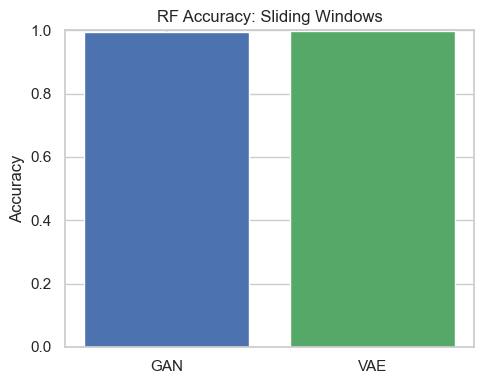

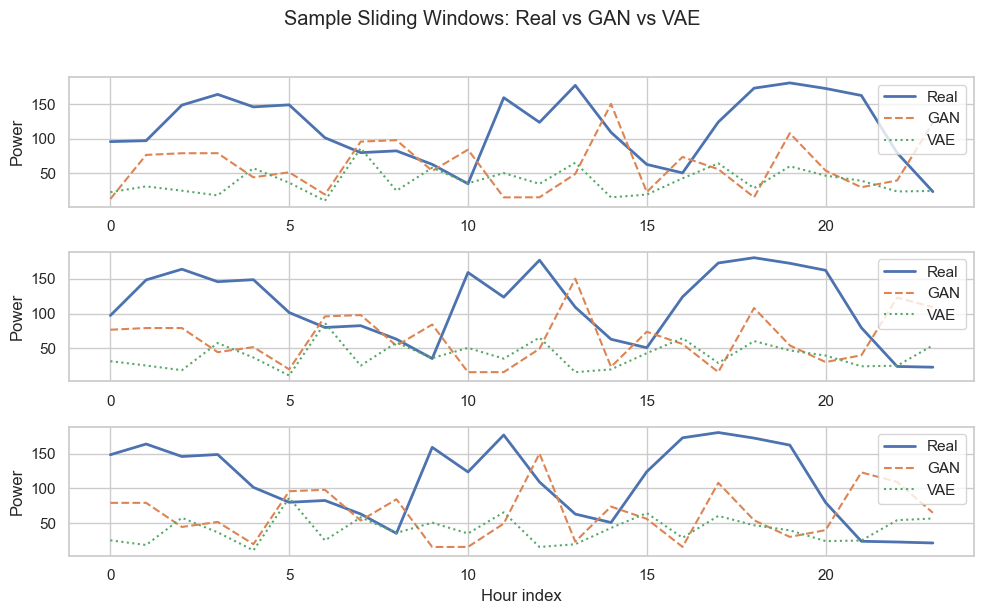

In [169]:
W = 24
data = year_df['Global_active_power'].values
win_real = np.stack([data[i:i+W] for i in range(len(data)-W+1)])
thr = np.percentile(win_real.max(axis=1), 90)
y_real = (win_real.max(axis=1) > thr).astype(int)
print(f'Real peaks: {y_real.sum()}, normals: {len(y_real)-y_real.sum()}')

# Build synthetic windows aligned to real count
build = lambda x: np.stack([x[i:i+W] for i in range(len(x)-W+1)])
win_gan = build(S_gan_full['Global_active_power'].values)[:len(win_real)]
win_vae = build(S_vae_full['Global_active_power'].values)[:len(win_real)]

# Classification accuracy
def class_acc(r, s, y):
    X = np.vstack([r, s])
    y_full = np.hstack([y, np.zeros(len(r),int)])
    Xtr,Xte,yt,ye = train_test_split(X, y_full, stratify=y_full, test_size=0.2, random_state=42)
    m = RandomForestClassifier(n_estimators=100, random_state=42).fit(Xtr, yt)
    return m.score(Xte, ye)
acc_gan = class_acc(win_real, win_gan, y_real)
acc_vae = class_acc(win_real, win_vae, y_real)
print(f'Accuracy GAN: {acc_gan:.2%}, VAE: {acc_vae:.2%}')

# Visualize sample windows: overlay first three
n_samples = 3
plt.figure(figsize=(10,6))
for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(win_real[i], label='Real', linewidth=2)
    plt.plot(win_gan[i], '--', label='GAN')
    plt.plot(win_vae[i], ':', label='VAE')
    plt.legend(loc='upper right'); plt.ylabel('Power')
plt.xlabel('Hour index')
plt.suptitle('Sample Sliding Windows: Real vs GAN vs VAE', y=1.02)
plt.tight_layout(); plt.show()

## 8. Short‑Term Forecasting with ARIMA

In [175]:
from statsmodels.tsa.arima.model import ARIMA

dly = df_power.set_index('dt').resample('D').sum().reset_index().rename(columns={'Global_active_power':'Value'})
train = dly.set_index('dt')['Value'][:-180]
train.index = pd.DatetimeIndex(train.index, freq='D')
test = dly.set_index('dt')['Value'][-180:]
test.index = pd.DatetimeIndex(test.index, freq='D')

# Synthetic daily series with frequency
gan_daily = S_gan_full.set_index(year_df.index)['Global_active_power'].resample('D').sum().rename('Value')
gan_daily.index = pd.DatetimeIndex(gan_daily.index, freq='D')
vae_daily = S_vae_full.set_index(year_df.index)['Global_active_power'].resample('D').sum().rename('Value')
vae_daily.index = pd.DatetimeIndex(vae_daily.index, freq='D')

# Forecast helper
def forecast_mae(train_s, syn_s, label):
    future = syn_s.iloc[:60]
    future.index = pd.date_range(start=train_s.index[-1] + pd.Timedelta(days=1), periods=len(future), freq='D')
    aug = pd.concat([train_s, future])
    model = ARIMA(aug, order=(5,1,0)).fit()
    preds = model.predict(start=test.index[0], end=test.index[-1])
    print(f"MAE ({label} augment):", (preds - test).abs().mean())

forecast_mae(train, gan_daily, 'GAN')
forecast_mae(train, vae_daily, 'VAE')
# Real-only baseline
model_real = ARIMA(train, order=(5,1,0)).fit()
preds_real = model_real.predict(start=test.index[0], end=test.index[-1])
print('MAE (Real-only):', (preds_real - test).abs().mean())

MAE (GAN augment): 425.53838207457125
MAE (VAE augment): 424.8428832125122
MAE (Real-only): 464.71655067765556
